In [1]:
# import packages
import glob
from pathlib import Path
import scipy.stats
import os
import numpy as np
from datetime import datetime
from datetime import timedelta
import pandas as pd
import calendar
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import cartopy.crs as ccrs
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from pathos.threading import ThreadPool as Pool
from scipy.stats import gaussian_kde
import xarray as xr
from matplotlib import cm
import matplotlib
from collections import Counter

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from f_sr_calculation import *

In [4]:
# work_dir=Path("/scratch/fransjevanoors/global_sr")
work_dir=Path("/mnt/u/LSM root zone/global_sr")

In [5]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# 2. optimize beta

In [38]:
df = pd.read_csv(f'{work_dir}/data/irrigated_area/output/combined_ia.csv',index_col=0) 

In [ ]:
el_id_list=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/se/*.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-10] # remove .year extension
    el_id_list.append(f)
print(len(el_id_list))

# get fiwu values for catchments with ia>0, se only written for ia>0, sd for all catchments
f = 'iwu2'
fm = []
for catch_id in el_id_list:
    if os.path.exists(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/se/{catch_id}_f{f}.csv'):
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/se/{catch_id}_f{f}.csv',index_col=0)
        fmean = d['f'][:-1].mean()
        fm.append(fmean)
print(len(fm))

In [ ]:
d=pd.DataFrame(index=el_id_list, columns=['fiwu'])
d['fiwu']=fm
d['ia'] = df['hi']
d['fopt'] = d['fiwu']/d['ia']
d.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f_optimization2.csv')

In [39]:
d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f_optimization2.csv',index_col=0)
d

,fiwu,ia,fopt
ITEMI002,0.021073,0.025706,0.819797
at_0000002,0.000000,0.000283,0.000000
at_0000008,0.000000,0.000526,0.000000
at_0000012,0.000000,0.000650,0.000000
at_0000039,0.000002,0.000003,0.621673
...,...,...,...
ITTOS343,0.014590,0.013244,1.101644
ITTOS361,0.129887,0.051705,2.512075
ITTOS339,0.065910,0.025785,2.556098
ITTOS372,0.117494,0.042303,2.777431


In [40]:
# MINIMIZE ABSOLUTE ERROR
f_min=0
f_max=4
nmax=10000
# A=np.zeros((int(nmax),8))
b = np.linspace(0,2.5,1000)
A=np.zeros((len(b),8))

# for n in range(1,int(nmax+1)): 
#     Rnum=np.random.rand(1)
#     f = f_min+(f_max-f_min)*Rnum

for n in range(1,len(b)+1):
    f = b[n-1]
    o = f*d['ia']
    er = o-d['fiwu']
    er_m = er.mean()
    er_mse = np.mean(er**2)
    er_mae = np.mean(np.abs(er))
    er_std =er.std()
    er_med = er.median()
    er_iqr =er.quantile(0.75) - er.quantile(0.25)
    er_rmse = np.sqrt(np.mean((o-d['fiwu'])**2))
    
    A[n-1,:] = [f,er_m,er_mse,er_mae,er_std,er_med,er_iqr,er_rmse]

ind=find_nearest(A[:,1],0)
fopt_mean=np.round(A[ind,0],3)
    
ind=np.argmin(A[:,2],0)
fopt_mse=np.round(A[ind,0],3)

ind=np.argmin(A[:,3],0)
fopt_mae=np.round(A[ind,0],3)

ind=np.argmin(A[:,4])
fopt_std=np.round(A[ind,0],3)

ind=find_nearest(A[:,5],0)
fopt_median=np.round(A[ind,0],3)

ind=np.argmin(A[:,6])
fopt_iqr=np.round(A[ind,0],3)

ind=np.argmin(A[:,7])
fopt_rmse=np.round(A[ind,0],3)

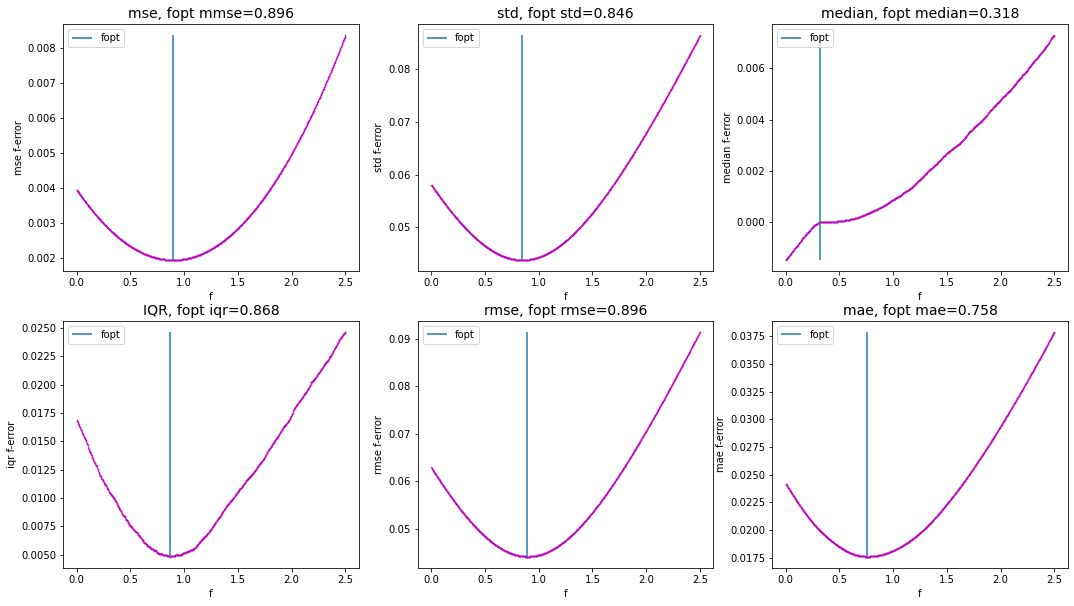

In [41]:
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(231)
ax.plot(A[:,0], A[:,2],'mo',markersize=0.5)
ax.vlines(fopt_mse,A[:,2].min(),A[:,2].max(), label='fopt')
ax.set_xlabel('f')
ax.set_ylabel('mse f-error')
ax.set_title(f'mse, fopt mmse={fopt_mse}',size=14)
ax.legend()

ax = fig.add_subplot(232)
ax.plot(A[:,0], A[:,4],'mo',markersize=0.5)
ax.vlines(fopt_std,A[:,4].min(),A[:,4].max(), label='fopt')
ax.set_xlabel('f')
ax.set_ylabel('std f-error')
ax.set_title(f'std, fopt std={fopt_std}',size=14)
ax.legend()

ax = fig.add_subplot(233)
ax.plot(A[:,0], A[:,5],'mo',markersize=0.5)
ax.vlines(fopt_median,A[:,5].min(),A[:,5].max(), label='fopt')
ax.set_xlabel('f')
ax.set_ylabel('median f-error')
ax.set_title(f'median, fopt median={fopt_median}',size=14)
ax.legend()

ax = fig.add_subplot(234)
ax.plot(A[:,0], A[:,6],'mo',markersize=0.5)
ax.vlines(fopt_iqr,A[:,6].min(),A[:,6].max(), label='fopt')
ax.set_xlabel('f')
ax.set_ylabel('iqr f-error')
ax.set_title(f'IQR, fopt iqr={fopt_iqr}',size=14)
ax.legend()

ax = fig.add_subplot(235)
ax.plot(A[:,0], A[:,7],'mo',markersize=0.5)
ax.vlines(fopt_rmse,A[:,7].min(),A[:,7].max(), label='fopt')
ax.set_xlabel('f')
ax.set_ylabel('rmse f-error')
ax.set_title(f'rmse, fopt rmse={fopt_rmse}',size=14)
ax.legend()

ax = fig.add_subplot(236)
ax.plot(A[:,0], A[:,3],'mo',markersize=0.5)
ax.vlines(fopt_mae,A[:,3].min(),A[:,3].max(), label='fopt')
ax.set_xlabel('f')
ax.set_ylabel('mae f-error')
ax.set_title(f'mae, fopt mae={fopt_mae}',size=14)
ax.legend()

# fig.savefig(f'{work_dir}/output/figures/irrigation/optimization/monte_carlo_absdiff.jpg',dpi=300,bbox_inches='tight')

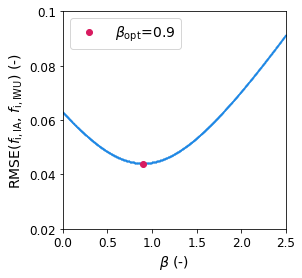

In [42]:
# RMSE figure optimization
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot(A[:,0], A[:,7],'o',color=c2,markersize=0.5)
ax.plot(1,1,'o',color=c2,markersize=6)
ax.plot(fopt_rmse,0.044,'o',color=c1,markersize=6,label=r'$\beta_{\mathrm{opt}}$='+str(np.round(fopt_rmse,1)))
ax.set_xlim(0,2.5)
ax.set_ylim(0.02,0.10)
ax.set_yticks([0.02,0.04,0.06,0.08,0.10])
ax.set_yticklabels([0.02,0.04,0.06,0.08,0.10],size=12)
ax.set_xticklabels([0.0,0.5,1.0,1.5,2.0,2.5],size=12)
ax.set_xlabel(r'$\beta$ (-)',fontsize=14)
ax.set_ylabel('RMSE($f_{\mathrm{i,IA}}$, $f_{\mathrm{i,IWU}}$) (-)',fontsize=14)
# ax.set_title('min(RMSE) for $f_{\mathrm{i,opt}}$='+str(fopt_rmse),size=14)
ax.legend(fontsize=14,loc='upper left')

,median,mean,std,iqr,rmse,mae
"fi,opt*IA - fi,iwu",0.001,-0.005,0.044,0.005,0.044,0.018


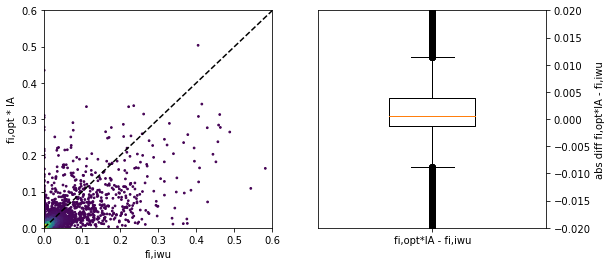

In [43]:
d['fi,opt'] = 0.9*d['ia']
d['dif'] = d['fi,opt']-d['fiwu']
d['reldif'] = (d['fi,opt']-d['fiwu'])/d['fiwu'] * 100

d = d.dropna()
x = d['fiwu']
y = d['fi,opt']

# calculate point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(121)
# ax.plot(d['fiwu'],d['f1.85ia'],'mo',markersize=1)
ax.scatter(x,y,c=z,s=3)
ax.plot([0,12],[0,12],'k--')
ax.set_xlabel('fi,iwu')
ax.set_ylabel('fi,opt * IA')
ax.set_xlim(0,0.6)
ax.set_ylim(0,0.6)

ax = fig.add_subplot(122)
d = d.dropna()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.boxplot(d['dif'])
ax.set_xticklabels(['fi,opt*IA - fi,iwu'])
ax.set_ylabel('abs diff fi,opt*IA - fi,iwu')
ax.set_ylim(-0.02,0.02)
ax.set_xlim(0.8,1.2)

de = d['dif']

e = pd.DataFrame(index=['fi,opt*IA - fi,iwu'])
e['median']=np.round(de.median(),3)
e['mean']=np.round(de.mean(),3)
e['std']=np.round(de.std(),3)
e['iqr'] = np.round((de.quantile(0.75) - de.quantile(0.25)),3)
e['rmse'] = np.round(np.sqrt(np.mean((de**2))),3)
e['mae'] = np.round(np.mean(np.abs(de)),3)
e

## SD CALCULATION

Run Sd calculation for three cases:
- NI
- IWU
- IAF

In [8]:
ir_case = 'iaf' # or 'ni' or 'iwu'
pep_dir = f'{work_dir}/output/forcing_timeseries/processed/daily'
q_dir = f'{work_dir}/output/q_timeseries_selected'
out_dir = f'{work_dir}/output/sr_calculation/sd_catchments'
snow_ids = np.genfromtxt(f'{work_dir}/output/snow/catch_id_list_snow_t_and_p.txt',dtype='str')
snow_dir = f'{work_dir}/output/snow/timeseries_gswp'

catch_list = np.genfromtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel_area_wb.txt',dtype='str')[:]

# # check which catchments are missing
# el_id_list=[]
# for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sd/*.csv'):
#     f = os.path.split(filepath)[1] # remove full path
#     f = f[:-11] # remove .year extension
#     el_id_list.append(f)
# dif = list(set(catch_list) - set(el_id_list))
# print(len(dif))
# catch_list = dif

catch_id_list = catch_list[0:3]
pep_dir_list = [pep_dir] * len(catch_id_list)
q_dir_list = [q_dir] * len(catch_id_list)
out_dir_list = [out_dir] * len(catch_id_list)
snow_id_list = [snow_ids] * len(catch_id_list)
snow_dir_list = [snow_dir] * len(catch_id_list)
work_dir_list = [work_dir] * len(catch_id_list)
ir_case_list = [ir_case] * len(catch_id_list)

run_sd_calculation_parallel(catch_id_list,pep_dir_list,q_dir_list,out_dir_list,snow_id_list,snow_dir_list,work_dir_list,ir_case_list)

## SR CALCULATION

In [6]:
ir_case = 'ni'
catch_list = np.genfromtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel_area_wb.txt',dtype='str')[:]

sd_list=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sd/*.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-11] # remove .year extension
    sd_list.append(f)

# define directories
sd_dir = f'{work_dir}/output/sr_calculation/sd_catchments'
out_dir = f'{work_dir}/output/sr_calculation/sd_catchments'

# define return periods
rp_array = [2,3,5,10,20,30,40,50,60,70,80]
catch_id_list = sd_list[0:3]
sd_dir_list = [sd_dir] * len(catch_id_list)
out_dir_list = [out_dir] * len(catch_id_list) 
rp_array_list = [rp_array] * len(catch_id_list) 
ir_case_list = [ir_case] * len(catch_id_list)

run_sr_calculation_parallel(catch_id_list,rp_array_list,sd_dir_list,out_dir_list,ir_case_list)

Combine calculated Sr values in one dataframe for each irrigation case:

In [9]:
# combine Sr output in dataframe - f no irri
c_list=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr/*gumbelfit.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-14] # remove .year extension
    c_list.append(f)
print(len(c_list))

sr_df_gf = pd.DataFrame(index=c_list, columns=['2','3','5','10','20','30','40','50','60','70','80'])
sr_df_p = pd.DataFrame(index=c_list, columns=['k3','k5'])
sr_df_gf.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr_no_irri_combined_gumbelfit.csv')
sr_df_p.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr_no_irri_combined_points.csv')

# sr_df_gf = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr_no_irri_combined_gumbelfit.csv',index_col=0)
# sr_df_p = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr_no_irri_combined_points.csv',index_col=0)
# sr_n = sr_df_p.dropna()

p = []
# p = sr_n.index
di = list(set(c_list) - set(p)) #missing catchments in dataframe
print(len(di))

for catch_id in di[:]:
    if os.path.exists(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr/{catch_id}_gumbelfit.csv'):
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr/{catch_id}_gumbelfit.csv',index_col=0)
        sr_df_gf.loc[catch_id] = d.iloc[0]
        
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr/{catch_id}_points.csv',index_col=0)
        l = [2]#,3,5,10,20,30,40,50,60,70,80]
        for i in range(len(l)):
            a = d['T_a'].values
            ix1 = find_nearest(a,l[i])
            sr = np.mean(d.sd.values[[ix1,ix1-1,ix1+1]])
            sr_df_p.loc[catch_id]['k3'] = sr
            
            a = d['T_a'].values
            ix1 = find_nearest(a,l[i])
            sr = np.mean(d.sd.values[[ix1,ix1-1,ix1+1,ix1-2,ix1+2]])
            sr_df_p.loc[catch_id]['k5'] = sr

sr_df_gf.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr_no_irri_combined_gumbelfit.csv')
sr_df_p.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr_no_irri_combined_points.csv')

4582
4582


In [12]:
# combine Sr output in dataframe - f0.9ia
c_list=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr/*gumbelfit.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-21] # remove .year extension
    c_list.append(f)
print(len(c_list))

sr_df_gf = pd.DataFrame(index=c_list, columns=['2','3','5','10','20','30','40','50','60','70','80'])
sr_df_p = pd.DataFrame(index=c_list, columns=['k3','k5'])
sr_df_gf.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr_irri_f0.9ia_combined_gumbelfit2.csv')
sr_df_p.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr_irri_f0.9ia_combined_points2.csv')

# sr_df_gf = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr_irri_f0.9ia_combined_gumbelfit.csv',index_col=0)
# sr_df_p = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr_irri_f0.9ia_combined_points.csv',index_col=0)
# sr_n = sr_df_p.dropna()

p=[]
# p = sr_n.index
di = list(set(c_list) - set(p)) #missing catchments in dataframe

for catch_id in di[:]:
    if os.path.exists(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr/{catch_id}_f0.9ia_gumbelfit.csv'):
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr/{catch_id}_f0.9ia_gumbelfit.csv',index_col=0)
        sr_df_gf.loc[catch_id] = d.iloc[0]
        
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr/{catch_id}_f0.9ia_points.csv',index_col=0)
        l = [2]#,3,5,10,20,30,40,50,60,70,80]
        for i in range(len(l)):
            a = d['T_a'].values
            ix1 = find_nearest(a,l[i])
            sr = np.mean(d.sd.values[[ix1,ix1-1,ix1+1]])
            sr_df_p.loc[catch_id]['k3'] = sr
            
            a = d['T_a'].values
            ix1 = find_nearest(a,l[i])
            sr = np.mean(d.sd.values[[ix1,ix1-1,ix1+1,ix1-2,ix1+2]])
            sr_df_p.loc[catch_id]['k5'] = sr

sr_df_gf.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr_irri_f0.9ia_combined_gumbelfit2.csv')
sr_df_p.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr_irri_f0.9ia_combined_points2.csv')

4583


In [18]:
# combine Sr output in dataframe - fiwu2
c_list=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr/*gumbelfit.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-20] # remove .year extension
    c_list.append(f)
print(len(c_list))

sr_df_gf = pd.DataFrame(index=c_list, columns=['2','3','5','10','20','30','40','50','60','70','80'])
sr_df_p = pd.DataFrame(index=c_list, columns=['k3','k5'])
sr_df_gf.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr_irri_fiwu2_combined_gumbelfit2.csv')
sr_df_p.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr_irri_fiwu2_combined_points2.csv')

# sr_df_gf = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr_irri_fiwu2_combined_gumbelfit2.csv',index_col=0)
# sr_df_p = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr_irri_fiwu2_combined_points2.csv',index_col=0)
sr_n = sr_df_gf.dropna()
# p=[]
p = sr_n.index
di = list(set(c_list) - set(p)) #missing catchments in dataframe

for catch_id in di[:]:
    if os.path.exists(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr/{catch_id}_fiwu2_gumbelfit.csv'):
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr/{catch_id}_fiwu2_gumbelfit.csv',index_col=0)
        sr_df_gf.loc[catch_id] = d.iloc[0]
        
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr/{catch_id}_fiwu2_points.csv',index_col=0)
        l = [2]#,3,5,10,20,30,40,50,60,70,80]
        for i in range(len(l)):
            a = d['T_a'].values
            ix1 = find_nearest(a,l[i])
            sr = np.mean(d.sd.values[[ix1,ix1-1,ix1+1]])
            sr_df_p.loc[catch_id]['k3'] = sr
            
            a = d['T_a'].values
            ix1 = find_nearest(a,l[i])
            sr = np.mean(d.sd.values[[ix1,ix1-1,ix1+1,ix1-2,ix1+2]])
            sr_df_p.loc[catch_id]['k5'] = sr

sr_df_gf.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr_irri_fiwu2_combined_gumbelfit2.csv')
sr_df_p.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr_irri_fiwu2_combined_points2.csv')

4582


## process Ss

In [87]:
el_id_list=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/se/*.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-10] # remove .year extension
    el_id_list.append(f)
print(len(el_id_list))

4635


In [88]:
catch_list = el_id_list[:]

# get fiwu values for catchments with ia>0, se only written for ia>0, sd for all catchments
f = '0.9ia'
fm = []
fs = []
fmd = []
ufm = []
ufs = []
ufmd = []
c = []
for catch_id in catch_list:
    if os.path.exists(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f{f}/se/{catch_id}_f{f}.csv'):
        if ((os.stat(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f{f}/se/{catch_id}_f{f}.csv').st_size == 0)==False):
            d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f{f}/se/{catch_id}_f{f}.csv',index_col=0)
            semean = d['se'][:-1].mean()
            sestd = d['se'][:-1].std()
            semed = d['se'][:-1].median()
            usemean = d['se_used'][:-1].mean()
            usestd = d['se_used'][:-1].std()
            usemed = d['se_used'][:-1].median()
            fm.append(semean)
            fs.append(sestd)
            fmd.append(semed)
            ufm.append(usemean)
            ufs.append(usestd)
            ufmd.append(usemed)
            c.append(catch_id)
print(len(fm))

4617


In [89]:
df = pd.DataFrame(index=c, columns=['se_mean','se_med','se_std','se_u_mean','se_u_med','se_u_std'])
df['se_mean'] = fm
df['se_med'] = fmd
df['se_std'] = fs
df['se_u_mean'] = ufm
df['se_u_med'] = ufmd
df['se_u_std'] = ufs

In [90]:
df

,se_mean,se_med,se_std,se_u_mean,se_u_med,se_u_std
ITEMI002,41.712954,0.000000,82.807757,0.965027,0.000000,1.915754
at_0000002,269.894526,238.107419,151.437294,0.068769,0.060670,0.038586
at_0000008,429.602336,472.816511,164.004743,0.217547,0.239431,0.083051
at_0000012,1061.950651,1119.515191,274.121193,0.415793,0.438332,0.107329
at_0000039,959.123427,919.755027,276.938776,0.002597,0.002491,0.000750
...,...,...,...,...,...,...
ITTOS343,87.114219,0.000000,129.124234,1.038349,0.000000,1.539084
ITTOS361,39.334022,0.000000,67.432614,1.830386,0.000000,3.137937
ITTOS339,58.810490,0.000000,97.039589,1.364800,0.000000,2.251973
ITTOS372,37.938966,0.000000,78.934075,1.444440,0.000000,3.005236


In [91]:
df.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f{f}/se_combined.csv')